## 🔧 Установка зависимостей

Устанавливаем необходимые библиотеки для обработки текста, работы с данными и нейросетевых моделей.

In [21]:
!pip install razdel

In [14]:
!pip install pandas nltk

In [1]:
import torch
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
from razdel import tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import zipfile

# Указываем путь к архиву
archive_path = '/content/drive/MyDrive/cabsar_v0.0.1.zip'

# Указываем директорию, куда будут извлечены файлы
extract_dir = './extracted_files'

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    # Извлекаем все файлы из архива
    zip_ref.extractall(extract_dir)

print(f'Файлы успешно извлечены в {extract_dir}')

Файлы успешно извлечены в ./extracted_files


In [42]:
def merge_jsonl_files(file1, file2, output_file):
    with open(output_file, 'w') as outfile:
        for filename in [file1, file2]:
            with open(filename, 'r') as infile:
                for line in infile:
                    outfile.write(line)

# Указываем пути к исходным файлам и путь к результирующему файлу
test = '/content/extracted_files/data/test.jsonl'
train = '/content/extracted_files/data/train.jsonl'
output = '/content/merged_data.jsonl'  # Путь к объединенному файлу

merge_jsonl_files(test, train, output)

merged_data = []
with open(output, 'r') as f:
    for line in f:
        merged_data.append(json.loads(line))

df = pd.DataFrame(merged_data)

## 🧩 Объединение обучающего и тестового наборов данных

Для удобства анализа объединяем два JSONL-файла (train и test) в один DataFrame.

In [43]:
merge_jsonl_files = '/content/merged_data.jsonl'

In [44]:
df = pd.read_json(merge_jsonl_files, lines=True)

# Вывод первых пяти строк датафрейма
print(df.head())

                                             context  \
0  {'text': 'Алена и Трандуил лечат меня всеми си...   
1  {'text': 'Пришла Женька когда я собиралась ухо...   
2  {'text': 'полное наебалово, в "Связном" нельзя...   
3  {'text': 'Если я не выиграю этого гребаного еж...   
4  {'text': 'на самом деле, Зейни с ними играется...   

                                              aspect  label   source  
0  {'text': 'Алена', 'aspect_loc': [{'pos_start':...      1  twitter  
1  {'text': 'Женька', 'aspect_loc': [{'pos_start'...      0  twitter  
2  {'text': 'Связном', 'aspect_loc': [{'pos_start...      2  twitter  
3  {'text': 'Сильвера', 'aspect_loc': [{'pos_star...      2  twitter  
4  {'text': 'Зейни', 'aspect_loc': [{'pos_start':...      0  twitter  


In [45]:
pd.DataFrame(df)

,context,aspect,label,source
0,{'text': 'Алена и Трандуил лечат меня всеми си...,"{'text': 'Алена', 'aspect_loc': [{'pos_start':...",1,twitter
1,{'text': 'Пришла Женька когда я собиралась ухо...,"{'text': 'Женька', 'aspect_loc': [{'pos_start'...",0,twitter
2,"{'text': 'полное наебалово, в ""Связном"" нельзя...","{'text': 'Связном', 'aspect_loc': [{'pos_start...",2,twitter
3,{'text': 'Если я не выиграю этого гребаного еж...,"{'text': 'Сильвера', 'aspect_loc': [{'pos_star...",2,twitter
4,"{'text': 'на самом деле, Зейни с ними играется...","{'text': 'Зейни', 'aspect_loc': [{'pos_start':...",0,twitter
...,...,...,...,...
6700,{'text': 'Я скучаю по Андрюше в Орле и Решке.'...,"{'text': 'Андрюше', 'aspect_loc': [{'pos_start...",1,twitter
6701,"{'text': 'Отличный вечер) Лизочка,люблю тебя,с...","{'text': 'Лизочка', 'aspect_loc': [{'pos_start...",1,twitter
6702,"{'text': 'Ну, вот и Градский решил похоронить ...","{'text': 'Градский', 'aspect_loc': [{'pos_star...",2,twitter
6703,"{'text': 'Дорогой Дедушка Мороз,я была хорошей...","{'text': 'Дедушка Мороз,я', 'aspect_loc': [{'p...",1,twitter


## 🧾 Просмотр и первичная проверка данных

Загружаем объединённый файл в `pandas.DataFrame`, выводим его содержимое и удаляем ненужные столбцы.

In [46]:
pd.DataFrame(df.drop('source', axis = 1))

,context,aspect,label
0,{'text': 'Алена и Трандуил лечат меня всеми си...,"{'text': 'Алена', 'aspect_loc': [{'pos_start':...",1
1,{'text': 'Пришла Женька когда я собиралась ухо...,"{'text': 'Женька', 'aspect_loc': [{'pos_start'...",0
2,"{'text': 'полное наебалово, в ""Связном"" нельзя...","{'text': 'Связном', 'aspect_loc': [{'pos_start...",2
3,{'text': 'Если я не выиграю этого гребаного еж...,"{'text': 'Сильвера', 'aspect_loc': [{'pos_star...",2
4,"{'text': 'на самом деле, Зейни с ними играется...","{'text': 'Зейни', 'aspect_loc': [{'pos_start':...",0
...,...,...,...
6700,{'text': 'Я скучаю по Андрюше в Орле и Решке.'...,"{'text': 'Андрюше', 'aspect_loc': [{'pos_start...",1
6701,"{'text': 'Отличный вечер) Лизочка,люблю тебя,с...","{'text': 'Лизочка', 'aspect_loc': [{'pos_start...",1
6702,"{'text': 'Ну, вот и Градский решил похоронить ...","{'text': 'Градский', 'aspect_loc': [{'pos_star...",2
6703,"{'text': 'Дорогой Дедушка Мороз,я была хорошей...","{'text': 'Дедушка Мороз,я', 'aspect_loc': [{'p...",1


In [ ]:
# Создаем словарь для хранения статистики
statistic = {}

for entry in df['aspect']:
    ner_type = entry['ner']

    if ner_type not in statistic:
        statistic[ner_type] = 1
    else:
        statistic[ner_type] += 1

print(statistic)

{'PER': 5070, 'ORG': 1635}


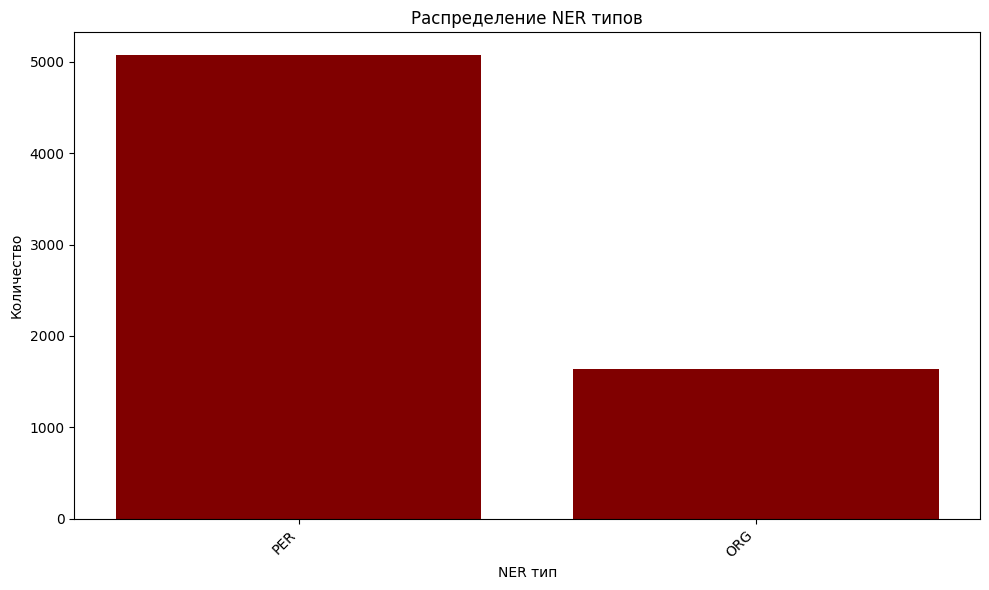

In [ ]:
import matplotlib.pyplot as plt

statistic = {} # Замените на вашу фактическую статистику

for entry in df['aspect']:
  ner_type = entry['ner']
  if ner_type not in statistic:
    statistic[ner_type] = 1
  else:
    statistic[ner_type] += 1


labels = list(statistic.keys())
values = list(statistic.values())

plt.figure(figsize=(10, 6)) # Увеличиваем размер графика для лучшей читаемости
plt.bar(labels, values, color='maroon')
plt.xlabel('NER тип')
plt.ylabel('Количество')
plt.title('Распределение NER типов')
plt.xticks(rotation=45, ha='right') # Поворачиваем подписи оси x для лучшей читаемости
plt.tight_layout() # Предотвращение наложения подписей
plt.show()

Распределение аспектов относительно сентимента:
   label  aspect_str
0      0        2967
1      1        2233
2      2        1316


<ipython-input-17-8767b037d2a7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='aspect_str', data=aspect_distribution, palette='flare')


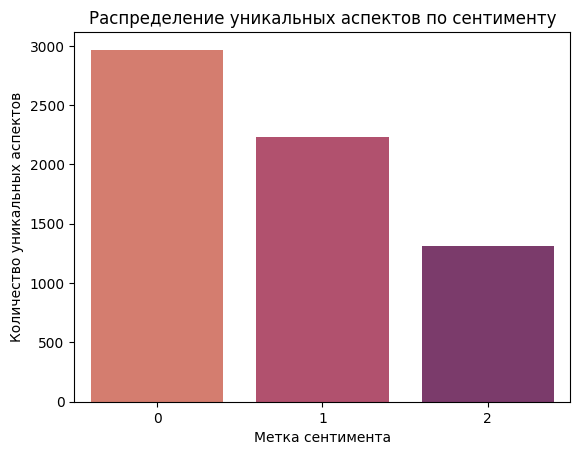

In [ ]:
import json

def aspect(df):
  df['aspect_str'] = df['aspect'].apply(lambda x: json.dumps(x))

  # Используем aspect_str в качестве ключа
  aspect_distribution = df.groupby('label')['aspect_str'].nunique().reset_index()

  print("Распределение аспектов относительно сентимента:")
  print(aspect_distribution)
  sns.barplot(x='label', y='aspect_str', data=aspect_distribution, palette='flare')
  plt.title('Распределение уникальных аспектов по сентименту')
  plt.xlabel('Метка сентимента')
  plt.ylabel('Количество уникальных аспектов')


  plt.show()
# Вывод распределения
aspect(df)



# 🔍 Указание модели и загрузка её токенизатора

In [47]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# 🧹 Подготовка данных к обучению

In [48]:
def prepare_data(df, tokenizer):
    """
    Преобразует датафрейм в входной формат для модели:
    соединяет аспект и контекст, выполняет токенизацию и возвращает тензоры.
    
    Args:
        df (pd.DataFrame): датафрейм с колонками 'aspect', 'context' и 'label'
        tokenizer (transformers.PreTrainedTokenizer): токенизатор модели
    
    Returns:
        encoded_inputs (dict): токенизированные данные
        labels (Tensor): тензор меток классов
    """
    texts = []
    labels = []

    for index, row in df.iterrows():
        context_text = row['context']['text']     # контекст (весь отзыв или фраза)
        aspect_text = row['aspect']['text']       # аспект 
        text = f"{aspect_text} - {context_text}"  # объединяем в одну строку
        texts.append(text)
        labels.append(row['label'])               # метка класса: 0, 1 или 2

    # Токенизация всех текстов сразу 
    encoded_inputs = tokenizer(
        texts,
        padding=True,            
        truncation=True,         
        return_tensors="pt"      
    )

    return encoded_inputs, torch.tensor(labels)

In [49]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

# 📊 Разделение данных на обучающую и валидационную выборки (80/20)

In [50]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    encoded_inputs['input_ids'], labels, test_size=0.2, random_state=42
)
train_attention_mask, val_attention_mask, _, _ = train_test_split(
    encoded_inputs['attention_mask'], labels, test_size=0.2, random_state=42
)

# 📦 Создание Dataset-класса для DataLoader

In [51]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)  # Кол-во примеров в датасете

    def __getitem__(self, idx):
        # Возвращаем словарь с входами модели и меткой класса
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [52]:
train_dataset = Dataset(train_inputs, train_attention_mask, train_labels)
val_dataset = Dataset(val_inputs, val_attention_mask, val_labels)

# 📈 Определение метрик для оценки качества модели

In [53]:
def compute_metrics(p):
    predictions = p.predictions.argmax(-1)
    accuracy = accuracy_score(p.label_ids, predictions)
    f1_macro = f1_score(p.label_ids, predictions, average='macro')
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
    }

# ⚙️ Настройка параметров обучения

In [56]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_dir="./logs",
)

# 🚀 Запуск процесса обучения

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.829726,0.616704,0.466691
2,0.918200,0.779411,0.638330,0.573246
3,0.715500,0.767900,0.654735,0.594266
4,0.715500,0.778569,0.656227,0.608056
5,0.589300,0.797681,0.651752,0.618653
6,0.513400,0.818053,0.647278,0.624505
7,0.513400,0.848475,0.639821,0.613536
8,0.442200,0.878429,0.648770,0.630036
9,0.398300,0.892578,0.642058,0.619170
10,0.398300,0.897934,0.643550,0.622666


TrainOutput(global_step=3360, training_loss=0.5721426555088588, metrics={'train_runtime': 135.2926, 'train_samples_per_second': 396.474, 'train_steps_per_second': 24.835, 'total_flos': 62593954839360.0, 'train_loss': 0.5721426555088588, 'epoch': 10.0})

# 🧪 Оценка модели на валидационном наборе

In [37]:
trainer.evaluate()

<ipython-input-27-81cdbd1c8951>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.6180217862129211,
 'eval_accuracy': 0.775390625,
 'eval_f1': 0.7555863197547121,
 'eval_runtime': 0.8075,
 'eval_samples_per_second': 1268.099,
 'eval_steps_per_second': 79.256,
 'epoch': 10.0}

In [39]:
model.save_pretrained("sentirueval_model")
tokenizer.save_pretrained("sentirueval_model")
fine_tuned_tokenizer = AutoTokenizer.from_pretrained("sentirueval_model")
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("sentirueval_model")

# Функция для предсказания тональности с использованием дообученной модели
def predict_sentiment_fine_tuned(text, tokenizer, model):
    """
    Предсказывает тональность текста с помощью дообученной модели.

    Args:
        text (str): входной текст (например, отзыв)
        tokenizer: токенизатор модели
        model: дообученная модель

    Returns:
        str: метка класса (например, 'positive', 'neutral', 'negative')
    """
    # Токенизация входного текста
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)  
        predicted_class = torch.argmax(probabilities, dim=-1).item()        

    sentiment_labels = label_encoder.inverse_transform([predicted_class])[0]
    return sentiment_labels

# Применяем модель к каждому тексту в датафрейме и записываем результат
df['predicted_sentiment_fine_tuned'] = df['input_text'].apply(
    lambda x: predict_sentiment_fine_tuned(x, fine_tuned_tokenizer, fine_tuned_model)
)
print(classification_report(df['sentiment'], df['predicted_sentiment_fine_tuned']))
f1_macro = f1_score(df['sentiment'], df['predicted_sentiment_fine_tuned'], average='macro')
print(f"F1-macro: {f1_macro}")
f1_micro = f1_score(df['sentiment'], df['predicted_sentiment_fine_tuned'], average='micro')
print(f"F1-micro: {f1_micro}")


              precision    recall  f1-score   support

        both       0.00      0.00      0.00        87
    negative       0.75      0.75      0.75       939
     neutral       0.55      0.33      0.42       491
    positive       0.88      0.94      0.91      3600

    accuracy                           0.83      5117
   macro avg       0.54      0.51      0.52      5117
weighted avg       0.81      0.83      0.82      5117

F1-macro: 0.5187107782569974
F1-micro: 0.8344733242134063


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# По аналогии обучаем модель на остальных корпусах данных, в блокноте представлено начальное и конечное обучение. Обучение на корпусах данных RuTermEval 2024, SemEval 2014, AspectRunningShoes по аналогии.

In [7]:
import zipfile
archive_path = '/content/drive/MyDrive/SentiRuEval.zip'
extract_dir = './extracted_files'

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'Файлы успешно извлечены в {extract_dir}')

Файлы успешно извлечены в ./extracted_files


In [8]:
import xml.etree.ElementTree as ET  # Импортируем модуль для работы с XML

def merge_xml_files(file1, file2, output_file):
    # Загружаем и парсим первый XML-файл
    tree1 = ET.parse(file1)
    root1 = tree1.getroot()  

    # Загружаем и парсим второй XML-файл
    tree2 = ET.parse(file2)
    root2 = tree2.getroot()  
    for child in list(root2):
        root1.append(child)
    tree1.write(output_file, encoding="utf-8", xml_declaration=True)

# Пути к исходным файлам и результирующему файлу
test = '/content/extracted_files/SentiRuEval/SentiRuEval_2016/SentiRuEval_test.xml'
train = '/content/extracted_files/SentiRuEval/SentiRuEval_2016/SentiRuEval_train.xml'
output = '/content/merged_data.xml'

merge_xml_files(test, train, output)

In [10]:
import xml.etree.ElementTree as ET

def xml_to_dataframe(xml_file):
  """Преобразует XML-файл в датафрейм Pandas.

  Args:
      xml_file (str): Путь к XML-файлу.

  Returns:
      pandas.DataFrame: Датафрейм, представляющий данные из XML-файла.
  """

  tree = ET.parse(xml_file)
  root = tree.getroot()

  reviews = []
  for review in root.findall('review'):
    review_data = {}
    review_data['id'] = review.get('id')
    review_data['object'] = review.find('meta/object').text
    review_data['text'] = review.find('text').text

    aspects = []
    for aspect in review.findall('aspects/aspect'):
      aspect_data = {
          'category': aspect.get('category'),
          'term': aspect.get('term'),
          'sentiment': aspect.get('sentiment'),
          'type': aspect.get('type'),
      }
      aspects.append(aspect_data)

    review_data['aspects'] = aspects

    categories = []
    for category in review.findall('categories/category'):
      category_data = {
          'name': category.get('name'),
          'sentiment': category.get('sentiment')
      }
      categories.append(category_data)

    review_data['categories'] = categories

    reviews.append(review_data)

  df = pd.DataFrame(reviews)
  return df

In [12]:
xml_file = '/content/extracted_files/SentiRuEval/SentiRuEval_2016/SentiRuEval_test.xml'
df = xml_to_dataframe(xml_file)
pd.DataFrame(df)

,id,object,text,aspects,categories
0,37784,Вильям Басс,По совету друзей посетили данное заведение. Бы...,"[{'category': 'Whole', 'term': 'заведение', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."
1,15655,Roll & Roll,Сегодня посетили этот ресторан с девушкой. Оче...,"[{'category': 'Whole', 'term': 'ресторан', 'se...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."
2,23369,Мамалыга,Сегодня с мужем побывали в этом ресторанчике.С...,"[{'category': 'Whole', 'term': 'ресторанчике',...","[{'name': 'Food', 'sentiment': 'both'}, {'name..."
3,5211,Лига Паб,"Отличное место, особенно для больших компаний!...","[{'category': 'Whole', 'term': 'место', 'senti...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."
4,15335,Трес амигос,"Отдыхали с друзями, гуляли, отмечали День рожд...","[{'category': 'Whole', 'term': 'ресторан Трес ...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."
...,...,...,...,...,...
198,9878,Neverland,Пришли в данное заведение 4 июня 2014 года пок...,"[{'category': 'Whole', 'term': 'заведение', 's...","[{'name': 'Food', 'sentiment': 'negative'}, {'..."
199,28258,The kitchen,Заехали с мужем поужинать в пятницу ( 17.01.14...,"[{'category': 'Food', 'term': 'поужинать', 'se...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."
200,38031,Доски,"Пришел сегодня с друзьями, отметить день рожде...","[{'category': 'Interior', 'term': 'свободных с...","[{'name': 'Food', 'sentiment': 'neutral'}, {'n..."
201,33043,Шатер,Мне так там нравитсяяяя!!!!!!!!! Интерьер модн...,"[{'category': 'Interior', 'term': 'Интерьер', ...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."


In [13]:
df.drop('id', axis=1)

,object,text,aspects,categories
0,Вильям Басс,По совету друзей посетили данное заведение. Бы...,"[{'category': 'Whole', 'term': 'заведение', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."
1,Roll & Roll,Сегодня посетили этот ресторан с девушкой. Оче...,"[{'category': 'Whole', 'term': 'ресторан', 'se...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."
2,Мамалыга,Сегодня с мужем побывали в этом ресторанчике.С...,"[{'category': 'Whole', 'term': 'ресторанчике',...","[{'name': 'Food', 'sentiment': 'both'}, {'name..."
3,Лига Паб,"Отличное место, особенно для больших компаний!...","[{'category': 'Whole', 'term': 'место', 'senti...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."
4,Трес амигос,"Отдыхали с друзями, гуляли, отмечали День рожд...","[{'category': 'Whole', 'term': 'ресторан Трес ...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."
...,...,...,...,...
198,Neverland,Пришли в данное заведение 4 июня 2014 года пок...,"[{'category': 'Whole', 'term': 'заведение', 's...","[{'name': 'Food', 'sentiment': 'negative'}, {'..."
199,The kitchen,Заехали с мужем поужинать в пятницу ( 17.01.14...,"[{'category': 'Food', 'term': 'поужинать', 'se...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."
200,Доски,"Пришел сегодня с друзьями, отметить день рожде...","[{'category': 'Interior', 'term': 'свободных с...","[{'name': 'Food', 'sentiment': 'neutral'}, {'n..."
201,Шатер,Мне так там нравитсяяяя!!!!!!!!! Интерьер модн...,"[{'category': 'Interior', 'term': 'Интерьер', ...","[{'name': 'Food', 'sentiment': 'positive'}, {'..."


In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ast
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Функция предобработки текста

In [16]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('russian'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

In [17]:
df['processed_text'] = df['text'].apply(preprocess_text)

# Извлекает из строки DataFrame списки:
- аспектных терминов,
- категорий аспектов,
- оценок сентимента.

In [18]:
def extract_aspect_data(row):
    aspect_terms = []
    aspect_categories = []
    aspect_sentiments = []
    for aspect in row['aspects']:
        aspect_terms.append(aspect['term'])
        aspect_categories.append(aspect['category'])
        aspect_sentiments.append(aspect['sentiment'])
    return aspect_terms, aspect_categories, aspect_sentiments

df['aspect_terms'], df['aspect_categories'], df['aspect_sentiments'] = zip(*df.apply(extract_aspect_data, axis=1))

In [ ]:
df = df.explode(['aspect_terms', 'aspect_categories', 'aspect_sentiments'])
df = df.rename(columns={'aspect_terms': 'term', 'aspect_categories': 'category', 'aspect_sentiments': 'sentiment'})

print(df[['text', 'processed_text', 'term', 'category', 'sentiment']].head())

In [20]:
pd.DataFrame(df)

,id,object,text,aspects,categories,processed_text,term,category,sentiment
0,37784,Вильям Басс,По совету друзей посетили данное заведение. Бы...,"[{'category': 'Whole', 'term': 'заведение', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'...",совету друзей посетили данное заведение пятниц...,заведение,Whole,neutral
0,37784,Вильям Басс,По совету друзей посетили данное заведение. Бы...,"[{'category': 'Whole', 'term': 'заведение', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'...",совету друзей посетили данное заведение пятниц...,Очень людно,Interior,negative
0,37784,Вильям Басс,По совету друзей посетили данное заведение. Бы...,"[{'category': 'Whole', 'term': 'заведение', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'...",совету друзей посетили данное заведение пятниц...,пиво,Food,positive
0,37784,Вильям Басс,По совету друзей посетили данное заведение. Бы...,"[{'category': 'Whole', 'term': 'заведение', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'...",совету друзей посетили данное заведение пятниц...,большой выбор,Food,positive
0,37784,Вильям Басс,По совету друзей посетили данное заведение. Бы...,"[{'category': 'Whole', 'term': 'заведение', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'...",совету друзей посетили данное заведение пятниц...,кухни,Food,neutral
...,...,...,...,...,...,...,...,...,...
202,16630,Рица,Уютная и тёплая домашняя обстановка! Милый и о...,"[{'category': 'Interior', 'term': 'Уютная', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'...",уютная тёплая домашняя обстановка милый отзывч...,обслуживание,Service,positive
202,16630,Рица,Уютная и тёплая домашняя обстановка! Милый и о...,"[{'category': 'Interior', 'term': 'Уютная', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'...",уютная тёплая домашняя обстановка милый отзывч...,Еда,Food,positive
202,16630,Рица,Уютная и тёплая домашняя обстановка! Милый и о...,"[{'category': 'Interior', 'term': 'Уютная', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'...",уютная тёплая домашняя обстановка милый отзывч...,персоналу,Service,positive
202,16630,Рица,Уютная и тёплая домашняя обстановка! Милый и о...,"[{'category': 'Interior', 'term': 'Уютная', 's...","[{'name': 'Food', 'sentiment': 'positive'}, {'...",уютная тёплая домашняя обстановка милый отзывч...,ресторан,Whole,positive


In [24]:
def create_input_text(row):
    # Создаем текстовый вход для модели, объединяя аспектный термин и предобработанный текст через стрелку
    return f"{row['term']} -> {row['processed_text']}"

# Применяем функцию к каждой строке DataFrame, создавая новую колонку 'input_text'
df['input_text'] = df.apply(create_input_text, axis=1)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Кодируем метки сентимента в числовой формат (например, позитивный -> 1, негативный -> 0 и т.п.)
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

In [25]:
# Разбиваем данные на обучающую и валидационную выборки в соотношении 80/20
train_texts, val_texts, train_labels, val_labels = train_test_split(
        df['input_text'].tolist(), df['sentiment_encoded'].tolist(), test_size=0.2, random_state=42
    )

In [ ]:
# Загружаем модель
model_name = "sentirueval_model"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors="pt")

In [27]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        """
        Инициализация датасета.
        
        :param encodings: словарь токенизированных входов (input_ids, attention_mask и т.д.)
        :param labels: список или тензор меток (label для каждого примера)
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Получение одного элемента датасета по индексу.
        
        Возвращает словарь, где ключи — это ключи из токенизаций (например, 'input_ids', 'attention_mask'),
        значения — соответствующие тензоры для данного индекса, а также добавляется ключ 'labels' с меткой.
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [28]:
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# ⚙️ Настройка параметров обучения

In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
        output_dir='./results',
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
    )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        f1 = f1_score(labels, preds, average='weighted')
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'f1': f1,
        }

# 🚀 Запуск процесса обучения

In [36]:
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zalinaabregova9 (zalinaabregova9-itmo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<ipython-input-27-81cdbd1c8951>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,0.764900
1000,0.616100
1500,0.545100
2000,0.500900
2500,0.479800


<ipython-input-27-81cdbd1c8951>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-27-81cdbd1c8951>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-27-81cdbd1c8951>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-27-81cdbd1c8951>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=2560, training_loss=0.5783898174762726, metrics={'train_runtime': 147.4544, 'train_samples_per_second': 277.577, 'train_steps_per_second': 17.361, 'total_flos': 128545489500960.0, 'train_loss': 0.5783898174762726, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.4502478241920471,
 'eval_accuracy': 0.8705882352941177,
 'eval_f1': 0.8756209150326798,
 'eval_precision': 0.8920415224913496,
 'eval_recall': 0.8705882352941177,
 'eval_runtime': 0.5075,
 'eval_samples_per_second': 334.963,
 'eval_steps_per_second': 21.674,
 'epoch': 10.0}

# Сохраняем модель

In [60]:
model.save_pretrained("mix_model")
tokenizer.save_pretrained("mix_model")

('mix_model/tokenizer_config.json',
 'mix_model/special_tokens_map.json',
 'mix_model/vocab.txt',
 'mix_model/added_tokens.json',
 'mix_model/tokenizer.json')

# Пример использования

In [40]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "mix_model"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.eval()

test_data = [
    ("Экран очень яркий и четкий."),
    ("Звук вроде хороший, но все равно немного тихий."),
]
def create_input_text(term, processed_text):
    return f"{term} -> {processed_text}"

test_texts = [create_input_text(term, text) for term, text in test_data]
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**test_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()
predicted_sentiments = label_encoder.inverse_transform(predictions)
for i, text in enumerate(test_texts):
    print(f"Acпект: {text}")
    print(f"Предсказанная тональность: {predicted_sentiments[i]}")
    print("-" * 20)

Acпект: экран -> Экран очень яркий и четкий.
Предсказанная тональность: positive
--------------------
Acпект: звук -> Звук вроде хороший, но все равно немного тихий.
Предсказанная тональность: negative
--------------------
